# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [7]:
USER_NAME = u"Рогачёв".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
def sigmoid (val):
    return 1.0/(np.exp (-val) + 1)

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        
    def grad (self, x, y):#here x is only one element and y is just +-1
        return x * (sigmoid (-x.dot(self.beta)) -  y)
    
    def error_print (self, x, y):
        err = 0
        for i in range (x.shape[0]):
            err -= np.log (sigmoid (-x[i].dot(self.beta))) * y[i] + (1 - np.log (sigmoid (-x[i].dot(self.beta)))) *(1 - y[i])
#         print "error:",err
        return err
    
    def fit(self, X, y=None, partial_fit=False):
        '''
        Обучение модели
        '''
        self.errors = []
        x = np.concatenate ((X, np.ones((X.shape[0],1))), axis=1)#and we use x instead of X
        if not partial_fit:
            self.beta = np.ones(x.shape[1])#initialisation of beta array may be improved
        for epoch in range(1,self.max_epoch):  
            shuffled = random.sample (range(x.shape[0]), x.shape[0])
            for iteration, i in enumerate (shuffled):
                self.beta = self.beta + self.alpha / epoch * self.grad (x[i], y[i])
                for b in range(self.beta.shape[0]):#L1 regularisation with clipping http://www.aclweb.org/anthology/P09-1054
                    if self.beta[b] > 0:
                        self.beta[b] -= 1.0 / self.C * self.alpha / epoch
                    else:
                        if self.beta[b] < 0:
                            self.beta[b] += 1.0 / self.C * self.alpha / epoch
#             to draw plot for every epoch
#             plt.plot ([-4,8], [(4 * self.beta[0] - self.beta[2]) / self.beta[1], (-8* self.beta[0] - self.beta[2]) / self.beta[1]])
            self.errors.append (self.error_print (x, y))
            
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self.fit (X,y,partial_fit=True)#just do not recreate beta array  
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = []
        x = np.concatenate ((X, np.ones((X.shape[0],1))), axis=1)#and we use x instead of X
        for i in range (x.shape[0]):
            if sigmoid (-x[i].dot(self.beta)) > 0.5:
                y_hat.append (1)
            else:
                y_hat.append (0)
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = []
        x = np.concatenate ((X, np.ones((X.shape[0],1))), axis=1)#and we use x instead of X
        for i in range (x.shape[0]):
            y_hat_proba.append ( sigmoid (-x[i].dot(self.beta)) > 0.5)
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

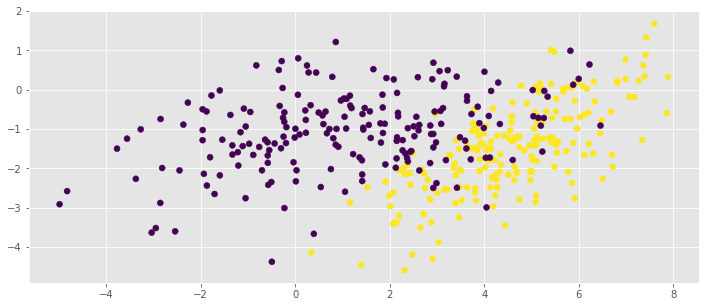

In [14]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

weights(the last coefitient is for constant): [-1.29917382  1.40264426  5.80568153]


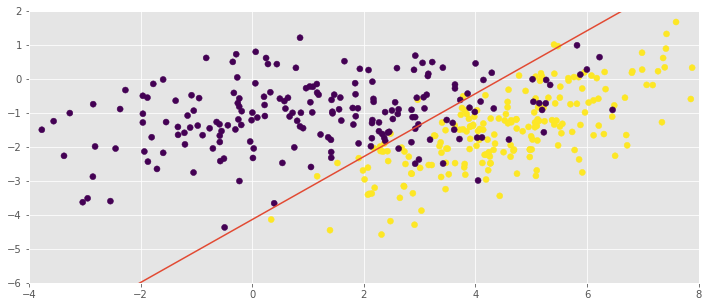

In [15]:
model = MySGDClassifier(alpha=0.2, max_epoch=40, C=200)
model.fit(X, y)
print "weights(the last coefitient is for constant):",model.beta
plt.plot ([-4,8], [(4 * model.beta[0] - model.beta[2]) / model.beta[1], (-8* model.beta[0] - model.beta[2]) / model.beta[1]])
plt.scatter(X[:,0], X[:,1], c=y)
axes = plt.gca()
axes.set_xlim([-4,8])
axes.set_ylim([-6,2])
plt.show ()

In [16]:
## Your Code Here

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

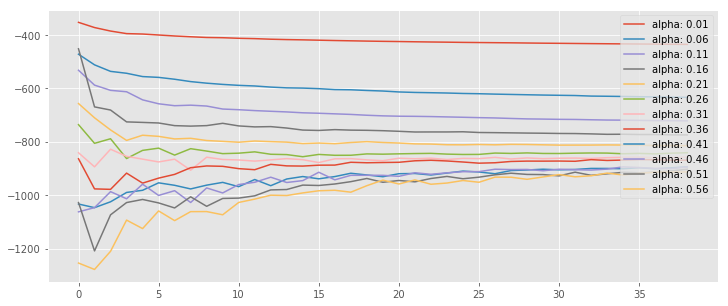

In [18]:
for alpha in np.arange (0.01, 0.6, 0.05):
    model = MySGDClassifier(alpha=alpha, max_epoch=40, C=200)
    model.fit(X, y)
    plt.plot (model.errors, label='alpha: ' + str(alpha))
plt.legend (loc = 1)

Разность в абсолютных значениях объясняется разными значениями вектора $w$. Но как видно из графиков значения до $\alpha = 0.26$ подходят хорошо и градиентный спуск показывает хорошее уменьшение функции ошибки.

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [23]:
!unzip data/trainingData_tabular.zip

Archive:  data/trainingData_tabular.zip
  inflating: trainingData_tabular_chunk4.csv  
  inflating: trainingData_tabular_chunk1.csv  
  inflating: trainingData_tabular_chunk2.csv  
  inflating: trainingData_tabular_chunk3.csv  


In [26]:
!mv trainingData_tabular_chunk* data/

In [28]:
!ls

data  hw4-Rogachev.ipynb  README.md


In [20]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './data/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [21]:
df_data.shape

(500000, 45)

In [22]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [38]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [24]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [3]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [41]:
X_train, y_train = df_data.drop('decision',axis =1).values, df_data.decision.values

In [43]:
enc.fit(X_train)

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [47]:
enc.n_values_

array([  31,   22,    8, 1236,   31,    2,    5,   11,   11,   27,    7,
         11,    8,   20,    8, 1236,   31,    2,    5,   11,   11,   27,
          6,   11,    8,    8,   50,   36,   47,   53,    8,   60,   37,
         46,   55,   11,    8,    5,   11,   11,   50,   55,   56])

In [62]:
df_data.opponent_hero_card_id.value_counts()

798     67578
494     63623
25      62067
1235    60777
612     53141
981     51628
326     50802
754     46006
390     44378
Name: opponent_hero_card_id, dtype: int64

In [63]:
df_data.player_hero_card_id.value_counts()

1235    63625
25      61749
494     59371
798     58893
754     55605
612     54140
981     53092
390     47015
326     46510
Name: player_hero_card_id, dtype: int64

По 9 уникальных карт героя для оппонента и игрока.

In [58]:
test = enc.transform(X_train).toarray()

In [59]:
test.shape

(500000, 917)

Зачем дропать прежние столбцы, если их всего 45, а новых 917? Просто запишем новый X_train и дело с концом. Заодно нужно написать функцию, которая это будет делать сама - не всё же руками перебирать.

In [64]:
X_train = test

In [4]:
def ReadEncode(filepath):
    df_data = pd.read_csv(filepath, sep=',')
    df_data.columns = df_data.columns.str.replace('.', '_')
    df_data = df_data.set_index('gamestate_id')
    X_train, y_train = df_data.drop('decision',axis =1).values, df_data.decision.values
    enc.fit(X_train)
    return enc.transform(X_train).toarray(), y_train

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [5]:
filepath = 'data/trainingData_tabular_chunk1.csv'
X_train, y_train = ReadEncode(filepath)

In [6]:
model = MySGDClassifier(alpha=0.2, max_epoch=10, C=200)
model.fit(X_train, y_train)

MemoryError: 

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [ ]:
## Youd Code Here